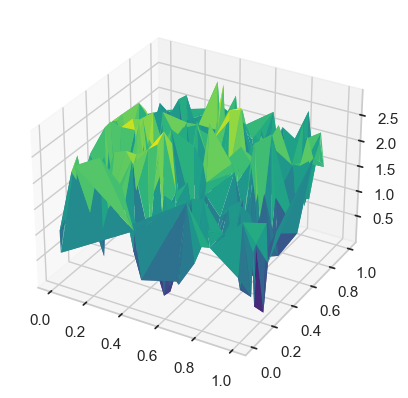

In [62]:
#Plot of geographical data
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot_trisurf(row, column, z,
                cmap='viridis', edgecolor='none')


(100,)


C:\Users\rasyd\AppData\Local\Temp\ipykernel_7692\539201549.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain = imread('SRTM_data_Norway_1.tif')


,alpha,degree,mse_train,mse_test,r2_train,r2_test
0,0,1,0.050754,0.096376,0.357356,0.108534
1,0,2,0.040425,0.076516,0.488147,0.292234
2,0,3,0.035026,0.082119,0.556502,0.240412
3,0,4,0.024931,0.064892,0.684327,0.399754
4,0,5,0.022438,0.104061,0.715895,0.037453


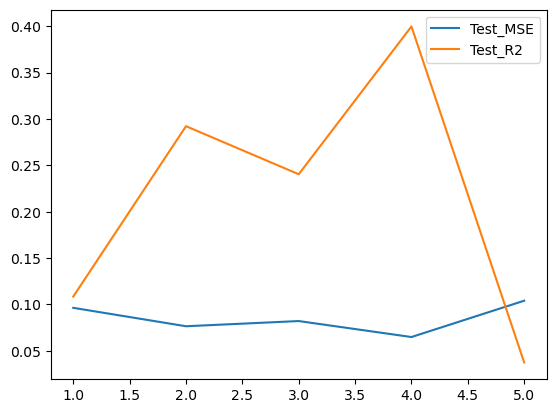

0    0.096376
1    0.076516
2    0.082119
3    0.064892
4    0.104061
Name: mse_test, dtype: float64

In [2]:

#Code for plotting the test-MSE and R^2 for OLS Regression fir on geographical data 
import numpy as np
import math
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from random import random, seed
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,MinMaxScaler
import math
from sklearn.pipeline import Pipeline
import pandas as pd
from imageio import imread
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoLars
from sklearn.utils import shuffle
from matplotlib import pyplot as plt


np.random.seed(1244)

#import Tarian data
terrain = imread('SRTM_data_Norway_1.tif')
N = 1000
#Devide into 1000 points
terrain = terrain[:N, :N]
#Sample 100 of those
sample_size=100
row = np.random.choice(N ,sample_size, replace=False)
column=np.random.choice(N , sample_size, replace=False)


samp=np.vstack([row,column]).T


z=terrain[samp[:,0],samp[:,1]] 



#Min max Scaling
row=row.reshape(-1, 1)
scaler1 =MinMaxScaler()
scaler1.fit(row)
row=scaler1.transform(row).ravel()
        
column=column.reshape(-1, 1)
scaler2 =MinMaxScaler()
scaler2.fit(column)
column=scaler2.transform(column).ravel()
        

z=z.reshape(-1, 1)
scaler3 =MinMaxScaler()
scaler3.fit(z)
z=scaler3.transform(z).ravel()+0.5*np.random.rand(sample_size)
print(z.shape)       
X_train,X_test,y_train,y_test=train_test_split(np.column_stack((row, column)),z,test_size=0.2)



y_scale=np.mean(y_train)

#Regression class that will be used in all simulations,here we only utilize the ols function
class RegressionClass:
    def __init__(self):
        pass

    def ols(self, degree, X_train, X_test, y_train, y_test, alpha):
        """
        Perform Ordinary Least Squares regression.

        Parameters:
            degree (int): Polynomial degree for regression.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            alpha (float): Regularization parameter (not used in OLS).

        Returns:
            float: Training MSE.
            float: Test MSE.
        """
        pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False))
                            ])
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.fit_transform(X_test)
        scaler =StandardScaler(with_std=False)
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        
        y_train = y_train- y_scale
        fit = np.linalg.pinv(X_train.T @ X_train) @ (X_train).T @ y_train
        y_hat_train = X_train @ fit.T
        y_hat_test = X_test @ fit.T+ y_scale
        result= np.array([mean_squared_error(y_train, y_hat_train),mean_squared_error(y_test, y_hat_test),r2_score(y_train, y_hat_train), r2_score(y_test, y_hat_test)])
        return result

    def ridge(self, degree, X_train, X_test, y_train, y_test, alpha):
        """
        Perform Ridge regression.

        Parameters:
            degree (int): Polynomial degree for regression.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            alpha (float): Regularization parameter for Ridge regression.

        Returns:
            float: Training MSE.
            float: Test MSE.
        """
        pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)) 
                             ])
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.fit_transform(X_test)
        scaler =StandardScaler(with_std=False)
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        W = X_train.T @ X_train
        y_train = y_train- y_scale
        fit = np.linalg.pinv(X_train.T @ X_train + alpha * np.eye(W.shape[1])) @ (X_train).T @ y_train
        y_hat_train = X_train @ fit.T
        y_hat_test = X_test @ fit.T+ y_scale
        result= np.array([mean_squared_error(y_train, y_hat_train),mean_squared_error(y_test, y_hat_test),r2_score(y_train, y_hat_train), r2_score(y_test, y_hat_test)])
        return result

    def lasso(self, degree, X_train, X_test, y_train, y_test, alpha):
        """
        Perform Lasso regression.

        Parameters:
            degree (int): Polynomial degree for regression.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            alpha (float): Regularization parameter for Lasso regression.

        Returns:
            float: Training MSE.
            float: Test MSE.
        """
        pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)),
                             ])
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.fit_transform(X_test)
        
        scaler =StandardScaler(with_std=False)
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        model = Lasso(alpha=alpha,tol=1, max_iter=1000)
        #y_train = y_train- y_scale
        model.fit(X_train, y_train)
        
        y_hat_train = model.predict(X_train)
        y_hat_test = model.predict(X_test)
        result= np.array([mean_squared_error(y_train, y_hat_train),mean_squared_error(y_test, y_hat_test),r2_score(y_train, y_hat_train), r2_score(y_test, y_hat_test)])
        return result

# RunRegression class definition
class RunRegression(RegressionClass):
    def __init__(self):
        self.regression_functions = {
            'ols': self.ols,
            'ridge': self.ridge,
            'lasso': self.lasso
        }

    def run(self, regression_type, alpha_values, degrees, X_train, X_test, y_train, y_test, use_bootstrap=False,
            use_kfold=False):
        """
        Run regression models with specified parameters.

        Parameters:
            regression_type (str): Type of regression ('ols', 'ridge', or 'lasso').
            alpha_values (list): List of alpha values for Ridge and Lasso regression.
            degrees (list): List of polynomial degrees for regression models.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            use_bootstrap (bool): Flag to indicate if bootstrap resampling should be performed.
            use_kfold (bool): Flag to indicate if K-Fold cross-validation should be performed.

        Returns:
            pandas.DataFrame: Dataframe containing regression results.
        """
        results = []

        for alpha in alpha_values:
            alpha_results = []

            for degree in degrees:
                mse_r_2_train_test = self.regression_functions[regression_type](degree, X_train, X_test, y_train, y_test,
                                                                            alpha)
                alpha_result = {
                    'alpha': alpha,
                    'degree': degree,
                    'mse_train': mse_r_2_train_test[0],
                    'mse_test':  mse_r_2_train_test[1],
                    'r2_train': mse_r_2_train_test[2],
                    'r2_test':  mse_r_2_train_test[3],
                }

              

                alpha_results.append(alpha_result)
            results.extend(alpha_results)
         
        result_df = pd.DataFrame(results)
        return result_df
    

# Create an instance of the RunRegression class
regression_instance = RegressionClass()
run_regression_instance = RunRegression()

# Define the alpha values and degrees
alpha_values = [0.00001, 0.00002, 0.00004, 0.0005]
degrees = list(range(1,6))

regression_type = 'ols'  # OLS regression

# Set alpha to 0 when calling the run method for OLS
result_df_ols = run_regression_instance.run(regression_type, [0], degrees,  X_train, X_test, y_train, y_test)

result_df_ols


from IPython.display import display


display(result_df_ols)



plt.plot(degrees,result_df_ols[result_df_ols.columns[3]], label='Test_MSE')
plt.plot(degrees, result_df_ols[result_df_ols.columns[5]], label='Test_R2')

plt.legend()
plt.show()

result_df_ols[result_df_ols.columns[3]]


C:\Users\rasyd\AppData\Local\Temp\ipykernel_7692\432407713.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain = imread('SRTM_data_Norway_1.tif')


[0.00322914 0.00646028 0.01169168 0.02728923 0.06251108 0.36991147]
   Polynomial Degree     Error      Bias  Variance
0                  1  0.084885  0.081656  0.003229
1                  2  0.075890  0.069429  0.006460
2                  3  0.100215  0.088523  0.011692
3                  4  0.134614  0.107325  0.027289
4                  5  0.145266  0.082755  0.062511
5                  6  0.456870  0.086958  0.369911


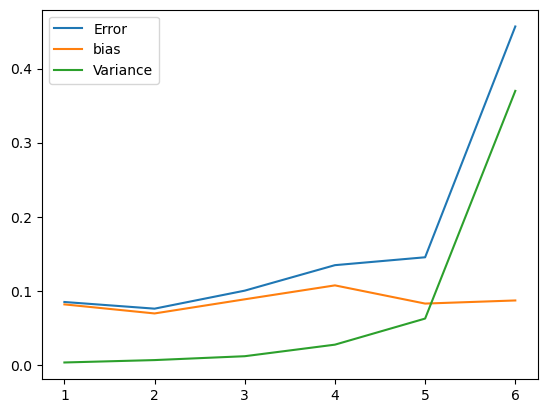

In [6]:


#Bias variance tradoff for OLS Regression when varrying polynomial degree up to 7.
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from imageio import imread
import pandas as pd
import seaborn as sns

np.random.seed(1233)
# Load terrain data
terrain = imread('SRTM_data_Norway_1.tif')
N = 500
terrain = terrain[:N, :N]

# Generate random sample indices
sample_size = 100
row = np.random.choice(N, sample_size, replace=False)
column = np.random.choice(N, sample_size, replace=False)

# Extract corresponding terrain heights
z = terrain[row, column]

# Scale features and target
row = row.reshape(-1, 1)
scaler1 = MinMaxScaler()
row = scaler1.fit_transform(row).ravel()

column = column.reshape(-1, 1)
scaler2 = MinMaxScaler()
column = scaler2.fit_transform(column).ravel()

z = z.reshape(-1, 1)
scaler3 = MinMaxScaler()
z = scaler3.fit_transform(z).ravel() + 0.5 * np.random.rand(sample_size)


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(np.column_stack((row, column)), z, test_size=0.2)

#Max degree 7
maxdegree = 7
#how many runs
n_boostraps = 100

#storing vectors
error_test = np.zeros(maxdegree-1)
bias_test = np.zeros(maxdegree-1)
variance_test = np.zeros(maxdegree-1)
polydegree = np.arange(1,maxdegree)



for degree in range(1,maxdegree):
    model1 = Pipeline([('poly', PolynomialFeatures(degree=degree , interaction_only=False))])
    y_pred_test = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        X_, y_ = resample(X_train, y_train,replace=True)
        X_=model1.fit_transform(X_)
        
        X_test1=model1.fit_transform(X_test)
        
        
        model=LinearRegression(fit_intercept=True)
        model.fit(X_, y_)
        y_pred_test[:, i] = model.predict(X_test1)
    
    error_test[degree-1] = np.mean(np.mean((y_test.reshape(-1,1) - y_pred_test) ** 2, axis=1, keepdims=True))
    bias_test[degree-1] = np.mean((y_test.reshape(-1,1) - np.mean(y_pred_test, axis=1, keepdims=True)) ** 2)
    variance_test[degree-1] = np.mean(np.var(y_pred_test, axis=1, keepdims=True))
print(variance_test)        
# Create a DataFrame for Seaborn plotting
data = pd.DataFrame({
    'Polynomial Degree': polydegree,
    'Error': error_test,
    'Bias': bias_test,
    'Variance': variance_test
})

print(data)

plt.plot(polydegree, error_test, label='Error')
plt.plot(polydegree, bias_test, label='bias')
plt.plot(polydegree, variance_test, label='Variance')
plt.legend()
plt.show()


In [19]:
#This code is used to compute all training,test,bootrap,cross valdation MSE for all models variyng both polynomial
#degree and tunining paramter for Ridge and Lasso.


#import packages
import numpy as np
import math
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from random import random, seed
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,MinMaxScaler
import math
from sklearn.pipeline import Pipeline
import pandas as pd
from imageio import imread
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoLars
from sklearn.utils import shuffle


#set seed
np.random.seed(1244)

#Import geographical image
terrain = imread('SRTM_data_Norway_1.tif')
N = 1000

# Descretize the image
terrain = terrain[:N, :N]


#Sample 100 points from the image bu sampling x and y coordiante and then extracting the image pixel value 
sample_size=100
row = np.random.choice(N ,sample_size, replace=False)
column=np.random.choice(N , sample_size, replace=False)


samp=np.vstack([row,column]).T


z=terrain[samp[:,0],samp[:,1]] 

#Min-Max scale on x,y and z
row=row.reshape(-1, 1)
scaler1 =MinMaxScaler()
scaler1.fit(row)
row=scaler1.transform(row).ravel()
        
column=column.reshape(-1, 1)
scaler2 =MinMaxScaler()
scaler2.fit(column)
column=scaler2.transform(column).ravel()
        

z=z.reshape(-1, 1)
scaler3 =MinMaxScaler()
scaler3.fit(z)
z=scaler3.transform(z).ravel()+0.5*np.random.rand(sample_size)
print(z.shape)       
X_train,X_test,y_train,y_test=train_test_split(np.column_stack((row, column)),z,test_size=0.2)


y_scale=np.mean(y_train)
# Bootstrap and KFold class definitions
class BootstrapKfold:
    def __init__(self):
        pass

    def bootstrap(self, n, function, degree, z, X_train, X_test, y_train, y_test, alpha):
        """
        Perform bootstrap resampling and calculate Cross-Validated Mean Squared Errors (MSE) for regression models.

        Parameters:
            n (int): Number of bootstrap samples.
            function (function): Regression function to be evaluated.
            degree (int): Polynomial degree for regression.
            z (array): Target values for regression.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            alpha (float): Regularization parameter (alpha) for Ridge and Lasso regression.

        Returns:
            float: Cross-validated mean training MSE.
            float: Cross-validated mean test MSE.
        """
        
        Boot_test_MSE = 0
        Boot_train_MSE = 0

        for i in range(n):
            indices = np.random.choice(X_train.shape[0], size=z.shape[0], replace=True)
            X_boot = X_train[indices]
            y_boot = y_train[indices]

            train_MSE, test_MSE = function(degree, X_boot, X_test, y_boot, y_test, alpha)

            Boot_test_MSE += test_MSE
            Boot_train_MSE += train_MSE

        Boot_test_MSE /= n
        Boot_train_MSE /= n

        return Boot_train_MSE, Boot_test_MSE

    def kfold(self, K, function, degree, z,X,alpha):
        """
        Perform K-Fold cross-validation and calculate Mean Squared Errors (MSE) for regression models.

        Parameters:
            K (int): Number of folds.
            function (function): Regression function to be evaluated.
            degree (int): Polynomial degree for regression.
            z (array): Target values for regression.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            alpha (float): Regularization parameter (alpha) for Ridge and Lasso regression.

        Returns:
            float: Cross-validated mean training MSE.
            float: Cross-validated mean test MSE.
        """
        
        
       
      

        #shuffle data
        X=shuffle(X, random_state=0)
        z=shuffle(z, random_state=0)
        
        #indexes for k-fold boundaries
        fold_size = int(math.ceil(len(z) / K))
        
        #initialize accumulation variables
        CV_test_MSE = 0
        CV_train_MSE = 0

        for i in range(len(z)):
            
            test_start = i * fold_size
            test_end = min((i + 1) * fold_size, len(z))
            start_stop = np.arange(test_start, test_end, 1)
            X_test_fold = X[start_stop]
            y_test_fold = z[start_stop]
            rest = np.setdiff1d(np.arange(z.shape[0]), start_stop)
            X_train_fold = X[rest]
            y_train_fold = z[rest]

            train_MSE, test_MSE = function(degree, X_train_fold, X_test_fold, y_train_fold, y_test_fold, alpha)

            CV_test_MSE += test_MSE
            CV_train_MSE += train_MSE

            if test_end == len(z):
                break

        CV_test_MSE /= K
        CV_train_MSE /= K

        return CV_train_MSE, CV_test_MSE

# RegressionClass definition
class RegressionClass:
    def __init__(self):
        pass

    def ols(self, degree, X_train, X_test, y_train, y_test, alpha):
        """
        Perform Ordinary Least Squares regression.

        Parameters:
            degree (int): Polynomial degree for regression.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            alpha (float): Regularization parameter (not used in OLS).

        Returns:
            float: Training MSE.
            float: Test MSE.
        """
        
        #create design matrices for test and training data
        pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False))
                            ])
        
        
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.fit_transform(X_test)
        
        
        #Center the design matrices column wise with X_trains column means
        scaler =StandardScaler(with_std=False)
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        
        #Center y_train
        y_train = y_train- y_scale
        #compute optimal parameters the minimizes the least squares
        fit = np.linalg.pinv(X_train.T @ X_train) @ (X_train).T @ y_train
        
        #fit the paramters to training and test design matrices
        y_hat_train = X_train @ fit.T
        
        #add intercept to get prediction on uncentered data
        y_hat_test = X_test @ fit.T+ y_scale
        #Compute the mean squares error
        mse_train_test = np.array([mean_squared_error(y_train, y_hat_train), mean_squared_error(y_test, y_hat_test)])
        return mse_train_test

    def ridge(self, degree, X_train, X_test, y_train, y_test, alpha):
        """
        Perform Ridge regression.

        Parameters:
            degree (int): Polynomial degree for regression.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            alpha (float): Regularization parameter for Ridge regression.

        Returns:
            float: Training MSE.
            float: Test MSE.
        """
        pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)) 
                             ])
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.fit_transform(X_test)
        scaler =StandardScaler(with_std=False)
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        W = X_train.T @ X_train
        y_train = y_train- y_scale
        fit = np.linalg.pinv(X_train.T @ X_train + alpha * np.eye(W.shape[1])) @ (X_train).T @ y_train
        y_hat_train = X_train @ fit.T
        y_hat_test = X_test @ fit.T+ y_scale
        mse_train_test = np.array([mean_squared_error(y_train, y_hat_train), mean_squared_error(y_test, y_hat_test)])
        return mse_train_test

    def lasso(self, degree, X_train, X_test, y_train, y_test, alpha):
        """
        Perform Lasso regression.

        Parameters:
            degree (int): Polynomial degree for regression.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            alpha (float): Regularization parameter for Lasso regression.

        Returns:
            float: Training MSE.
            float: Test MSE.
        """
        pipeline = Pipeline([('poly', PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)),
                             ])
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.fit_transform(X_test)
        
        scaler =StandardScaler(with_std=False)
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        model = Lasso(alpha=alpha,tol=1, max_iter=1000)
        #y_train = y_train- y_scale
        model.fit(X_train, y_train)
        
        y_hat_train = model.predict(X_train)
        y_hat_test = model.predict(X_test)
        mse_train_test = np.array([mean_squared_error(y_train, y_hat_train), mean_squared_error(y_test, y_hat_test)])
        return mse_train_test

# RunRegression class definition
class RunRegression(RegressionClass, BootstrapKfold):
    def __init__(self):
        self.regression_functions = {
            'ols': self.ols,
            'ridge': self.ridge,
            'lasso': self.lasso
        }

    def run(self, regression_type, alpha_values, degrees, X_train, X_test, y_train, y_test, use_bootstrap=False,
            use_kfold=False):
        """
        Run regression models with specified parameters.

        Parameters:
            regression_type (str): Type of regression ('ols', 'ridge', or 'lasso').
            alpha_values (list): List of alpha values for Ridge and Lasso regression.
            degrees (list): List of polynomial degrees for regression models.
            X_train (array): Training features.
            X_test (array): Testing features.
            y_train (array): Training target values.
            y_test (array): Testing target values.
            use_bootstrap (bool): Flag to indicate if bootstrap resampling should be performed.
            use_kfold (bool): Flag to indicate if K-Fold cross-validation should be performed.

        Returns:
            pandas.DataFrame: Dataframe containing regression results.
        """
        results = []
        #run for all polynomial complexities and tuning paramters defined
        for alpha in alpha_values:
            alpha_results = []

            for degree in degrees:
                mse_train_test = self.regression_functions[regression_type](degree, X_train, X_test, y_train, y_test,
                                                                            alpha)
                alpha_result = {
                    'alpha': alpha,
                    'degree': degree,
                    'mse_train': mse_train_test[0],
                    'mse_test': mse_train_test[1],
                }
                
                #include Bootstrap if condition is true
                if use_bootstrap:
                    cv_train_mse, cv_test_mse = self.bootstrap(1000, self.regression_functions[regression_type],
                                                               degree, z, X_train, X_test, y_train, y_test, alpha)
                    alpha_result['bootstrap_train_mse'] = cv_train_mse
                    alpha_result['bootstrap_test_mse'] = cv_test_mse
                #Include 5-CV if condition is true
                if use_kfold:
                    cv_train_mse, cv_test_mse = self.kfold(5, self.regression_functions[regression_type],
                                                           degree, z, np.column_stack((row, column)), alpha)
                    alpha_result['5cv_train_mse'] = cv_train_mse
                    alpha_result['5cv_test_mse'] = cv_test_mse
                 
                #Include 10-CV if condition is true
            
                if use_kfold:
                    cv_train_mse, cv_test_mse = self.kfold(10, self.regression_functions[regression_type],
                                                           degree, z, np.column_stack((row, column)), alpha)
                    alpha_result['10cv_train_mse'] = cv_train_mse
                    alpha_result['10cv_test_mse'] = cv_test_mse

                alpha_results.append(alpha_result)

            results.extend(alpha_results)

        result_df = pd.DataFrame(results)
        return result_df
    

# Create an instance of the RunRegression class
regression_instance = RegressionClass()
run_regression_instance = RunRegression()

# Define the alpha values and degrees
alpha_values = [0.00001, 0.00002, 0.00004, 0.0005]
degrees = list(range(1,6))

# Specify the type of regression ('ols', 'ridge', or 'lasso')
regression_type = 'ridge'  # Change to 'lasso' or 'ols' to run other regressions

# Call the run method to perform the specified regression
result_df_ridge = run_regression_instance.run(regression_type, alpha_values,degrees,X_train, X_test, y_train, y_test,use_bootstrap=True, use_kfold=True)


result_df_ridge

regression_type = 'ols'  # OLS regression

# Set alpha to 0 when calling the run method for OLS
result_df_ols = run_regression_instance.run(regression_type, [0], degrees,  X_train, X_test, y_train, y_test,use_bootstrap=True, use_kfold=True)

result_df_ols


regression_type = 'lasso'  # Lasso regression

result_df_lasso = run_regression_instance.run(regression_type,alpha_values, degrees, X_train, X_test, y_train, y_test,use_bootstrap=True, use_kfold=True)

result_df_lasso


from IPython.display import display

# Assuming you have multiple DataFrames df1, df2, df3
display(result_df_ridge)
display(result_df_ols)
display(result_df_lasso)

C:\Users\rasyd\AppData\Local\Temp\ipykernel_19796\2672100521.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain = imread('SRTM_data_Norway_1.tif')


(100,)


,alpha,degree,mse_train,mse_test,bootstrap_train_mse,bootstrap_test_mse,5cv_train_mse,5cv_test_mse,10cv_train_mse,10cv_test_mse
0,0.00001,1,0.050754,0.096376,0.050163,0.098441,0.059221,0.061775,0.059306,0.062387
1,0.00001,2,0.040425,0.076516,0.038797,0.080050,0.045827,0.051558,0.046096,0.050906
2,0.00001,3,0.035026,0.082101,0.032505,0.090699,0.040887,0.050705,0.041289,0.051742
3,0.00001,4,0.024955,0.064214,0.023066,0.078909,0.030166,0.046436,0.030633,0.048828
4,0.00001,5,0.022833,0.085175,0.020271,0.099585,0.027516,0.058253,0.028185,0.061911
5,0.00002,1,0.050754,0.096376,0.050479,0.098235,0.059221,0.061775,0.059306,0.062387
6,0.00002,2,0.040425,0.076517,0.039079,0.080137,0.045827,0.051558,0.046096,0.050906
7,0.00002,3,0.035026,0.082083,0.032632,0.091083,0.040887,0.050696,0.041289,0.051731
8,0.00002,4,0.025018,0.063810,0.023266,0.074386,0.030219,0.045643,0.030673,0.048017
9,0.00002,5,0.023064,0.081478,0.020815,0.095104,0.028205,0.055965,0.028799,0.059445


,alpha,degree,mse_train,mse_test,bootstrap_train_mse,bootstrap_test_mse,5cv_train_mse,5cv_test_mse,10cv_train_mse,10cv_test_mse
0,0,1,0.050754,0.096376,0.050079,0.098209,0.059221,0.061775,0.059306,0.062387
1,0,2,0.040425,0.076516,0.038880,0.080098,0.045827,0.051558,0.046096,0.050906
2,0,3,0.035026,0.082119,0.032583,0.092208,0.040887,0.050714,0.041289,0.051752
3,0,4,0.024931,0.064892,0.022952,0.076739,0.030146,0.047456,0.030619,0.049840
4,0,5,0.022438,0.104061,0.019383,0.187752,0.026528,0.073444,0.027416,0.079353


,alpha,degree,mse_train,mse_test,bootstrap_train_mse,bootstrap_test_mse,5cv_train_mse,5cv_test_mse,10cv_train_mse,10cv_test_mse
0,0.00001,1,0.050754,0.096371,0.049270,0.098471,0.058638,0.061770,0.058777,0.062269
1,0.00001,2,0.048113,0.090021,0.046452,0.092245,0.055196,0.058801,0.055354,0.059200
2,0.00001,3,0.045692,0.085458,0.044432,0.087883,0.052626,0.056720,0.052807,0.056998
3,0.00001,4,0.043706,0.083030,0.041894,0.086334,0.050896,0.055244,0.051087,0.055371
4,0.00001,5,0.042207,0.082428,0.040501,0.085802,0.049735,0.054142,0.049916,0.054156
5,0.00002,1,0.050754,0.096365,0.049154,0.098575,0.058638,0.061770,0.058777,0.062269
6,0.00002,2,0.048117,0.090024,0.046391,0.092454,0.055199,0.058805,0.055356,0.059203
7,0.00002,3,0.045691,0.085453,0.043990,0.088228,0.052627,0.056718,0.052808,0.056996
8,0.00002,4,0.043704,0.083024,0.042269,0.085942,0.050896,0.055240,0.051088,0.055369
9,0.00002,5,0.042208,0.082424,0.040385,0.085832,0.049735,0.054138,0.049917,0.054158


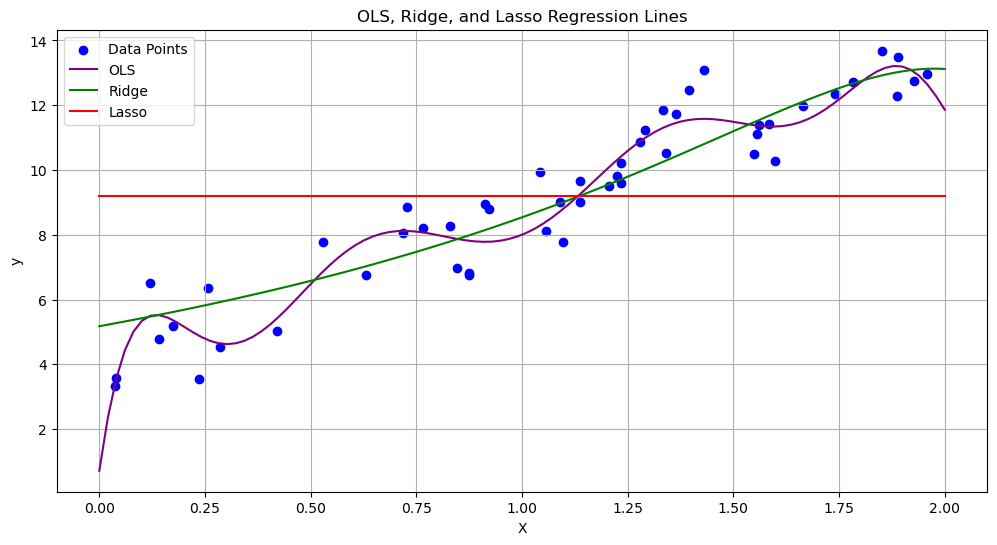

In [7]:
#plot illustrating the tuning paramter in Lasso and Ridge

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# Generate sample data
np.random.seed(0)
X = 2 * np.random.rand(50, 1)
y = 4 + 5 * X + np.random.randn(50, 1)

# Polynomial features
degree = 10
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly_features.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Create OLS, Ridge, and Lasso models
ols_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)  # Ridge regression
lasso_reg = Lasso(alpha=10)  # Lasso regression

# Fit models
ols_reg.fit(X_poly_scaled, y)
ridge_reg.fit(X_poly_scaled, y)
lasso_reg.fit(X_poly_scaled, y)

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(X, y, label='Data Points', color='blue')

# Plot OLS regression line
X_pred = np.linspace(0, 2, 100).reshape(-1, 1)
X_pred_poly = poly_features.transform(X_pred)
X_pred_poly_scaled = scaler.transform(X_pred_poly)
ols_y_pred = ols_reg.predict(X_pred_poly_scaled)
plt.plot(X_pred, ols_y_pred, label='OLS', color='purple')

# Plot Ridge regression line
ridge_y_pred = ridge_reg.predict(X_pred_poly_scaled)
plt.plot(X_pred, ridge_y_pred, label='Ridge', color='green')

# Plot Lasso regression line
lasso_y_pred = lasso_reg.predict(X_pred_poly_scaled)
plt.plot(X_pred, lasso_y_pred, label='Lasso', color='red')

plt.xlabel('X')
plt.ylabel('y')
plt.title('OLS, Ridge, and Lasso Regression Lines')
plt.legend()
plt.grid(True)
plt.show()